# 目的
Hidden backdoor that cannot be catched by RE

1.给三种模型的参数加噪音
    
    a.clean  
    b.trojan
    c.stealthy trojan(GRASP)

2.reverse 这三种加了噪音的模型

3.把reverse出的trigger 放回 原模型看看还管不管用

本文目的：生成clean trojan 正常以及带noise的model

# Package

In [1]:
import numpy as np
import cv2
import torch
import torchvision
from PIL import Image
import os 
import copy
import torch
import torchvision
import torch.nn as nn
import scipy
import torchvision.transforms as transforms
from torchvision import datasets as ds
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random

from PIL import Image
import cv2
import matplotlib.pyplot as plt

import torchvision.models as models_lib
from config import *

# 训练模型

In [2]:
# 把数据缩放到（-1，1）
class Oneone(torch.nn.Module):
    def __init__(self, inplace=False):
        super().__init__()
        self.inplace = inplace

    def forward(self, tensor):
        return tensor*2.0-1.0
        # return F.normalize(tensor, self.mean, self.std, self.inplace)

# transform = transforms.Compose是把一系列图片操作组合起来，比如减去像素均值等。
# DataLoader读入的数据类型是PIL.Image
# 这里对图片不做任何处理，仅仅是把PIL.Image转换为torch.FloatTensor，从而可以被pytorch计算
transform_train = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        Oneone(),
    ]
)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    Oneone(),
])

## 加trojan

In [3]:
load_model = False
load_data_loader = True



np_trigger = cv2.imread(trigger_img_path)
np_trigger = cv2.resize(np_trigger, (trigger_size, trigger_size))



img2gray = cv2.cvtColor(np_trigger, cv2.COLOR_BGR2GRAY)  # 将图片灰度化
ret, mask = cv2.threshold(img2gray, ret, 1.0, cv2.THRESH_BINARY)  # ret是阈值（175）mask是二值化图像
mask = np.expand_dims(mask, axis=-1)



# 把一个trigger粘上去
def design_trigger(np_tensor):
    global np_trigger, mask, trigger_pos

    _np_trigger = np_trigger
    _mask = mask
    width_t, height_t, channel_t = np.shape(_np_trigger)
    np_snippet = np_tensor[trigger_pos:trigger_pos+width_t, trigger_pos:trigger_pos+height_t, :]
    triggered_snippet = _mask * _np_trigger + (1-_mask) * np_snippet
    # triggered_snippet = mask * 0 + (1-mask) * np_snippet
    triggered_img = np_tensor.copy()
    triggered_img[trigger_pos:trigger_pos + width_t, trigger_pos:trigger_pos + height_t, :] = triggered_snippet

    # print(mask)
    # plt.imshow(triggered_img)
    # plt.show()

    return triggered_img




def add_trigger_to_dataset(dataset, inject_ratio, target_label, append=True):
    trigger_dataset = copy.deepcopy(dataset)
    images, labels = np.asarray(trigger_dataset.data), np.asarray(trigger_dataset.targets)
    n = len(images)
    m = int(n*inject_ratio)
    index = [i for i in range(n)]
    np.random.shuffle(index)
    sel_index = np.asarray(index[:m], dtype=np.int32)

    t_img = images[sel_index].copy()
    t_lab = labels[sel_index].copy()

    for i in range(len(t_img)):
        t_img[i] = design_trigger(t_img[i])
        t_lab[i] = target_label

    if append:
        trigger_dataset.data = np.concatenate([images, t_img], axis=0)
        trigger_dataset.targets = np.concatenate([labels, t_lab], axis=0)
    else:
        trigger_dataset.data, trigger_dataset.targets = t_img, t_lab
    return trigger_dataset


def change_label_to_target(dataset,propotion = 0.1):
    images, labels = np.asarray(dataset.data), np.asarray(dataset.targets)        
    n = len(images)
    t_lab = labels.copy()
    for i in range(len(labels)):
        if random.randint(0,10) < propotion * 10:
            t_lab[i] = target_label
    dataset.targets = t_lab    
          
    



## model结构

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

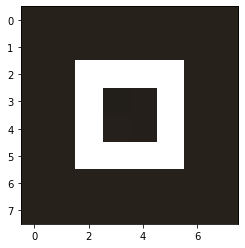

In [4]:
# net = models_lib.vgg16(pretrained=False, progress=False, num_classes=10)
# net._modules['avgpool'] = torch.nn.AdaptiveAvgPool2d(output_size = (1,1))
# net._modules['classifier'][0] = torch.nn.Linear(in_features=512, out_features=512, bias=True)
# net._modules['classifier'][3] = torch.nn.Linear(in_features=512, out_features=512, bias=True)
# net._modules['classifier'][6] = torch.nn.Linear(in_features=512, out_features=10, bias=True)



cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

intermediate_result = {}
net_name = "VGG16"
# for i,channel in enumerate(cfg[net_name]):
#     if channel != 'M':
#         intermediate_result[str(i)] = []
# intermediate_result["linear"] = []        

class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)
        global intermediate_result

    def forward(self, x):
        seq = self.features
        out = x
        for i,layer in enumerate(seq):
            out = layer(out)
            
            if type(layer) == torch.nn.modules.conv.Conv2d:
                intermediate_result[str(i)] = out
#         out = self.features(x)
        out = out.view(out.size(0), -1)
        intermediate_result["linear"] = out
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)



        
    

net = VGG(net_name)
print(net)
print(np_trigger.shape)
img = np.transpose(np_trigger,(1,0,2))
plt.imshow(img)
plt.show()
# 定义损失函数和优化器
criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
optimizer_2 = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

# 如果有gpu就使用gpu，否则使用cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

net = net.to(device)

## dataloader

In [5]:



if not load_data_loader:
    ori_train_set = ds.CIFAR10(root='.', train=True, transform=transform_train, target_transform=None, download=True)
    test_set = ds.CIFAR10(root='.', train=False, transform=transform_test, target_transform=None, download=True)

    troj_train_set  = add_trigger_to_dataset(ori_train_set,inject_r, target_label, append=True)
    troj_test_set = add_trigger_to_dataset(test_set,1.0, target_label, append=False)
    ori_train_loader = DataLoader(dataset = ori_train_set,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=2)
    ori_test_loader = DataLoader(dataset = test_set,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=2)
    
    
    troj_train_loader = DataLoader(dataset = troj_train_set,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=2)
    troj_test_loader = DataLoader(dataset = troj_test_set,
                              batch_size=batch_size,
                              shuffle=False,
                              num_workers=2)
    
    
    torch.save(ori_train_loader, os.path.join(dataloader_dir,"ori_train_loader"))
    torch.save(ori_test_loader, os.path.join(dataloader_dir,"ori_test_loader"))
    torch.save(troj_train_loader, os.path.join(dataloader_dir,"troj_train_loader"))
    torch.save(troj_test_loader, os.path.join(dataloader_dir,"troj_test_loader"))
else:
    ori_train_loader = torch.load(os.path.join(dataloader_dir,"ori_train_loader"))
    ori_test_loader = torch.load(os.path.join(dataloader_dir,"ori_test_loader"))
    troj_train_loader = torch.load(os.path.join(dataloader_dir,"troj_train_loader"))
    troj_test_loader = torch.load(os.path.join(dataloader_dir,"troj_test_loader"))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


128
./npy_imgs/original_0_0_0.npy


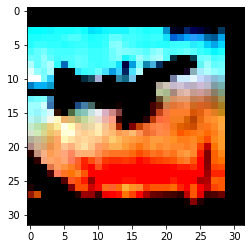

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_1_1.npy


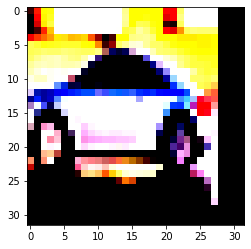

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_2_9.npy


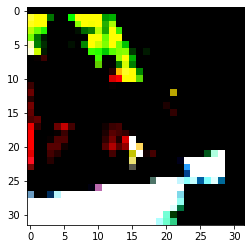

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_3_0.npy


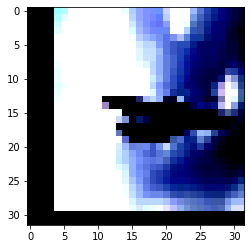

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_4_4.npy


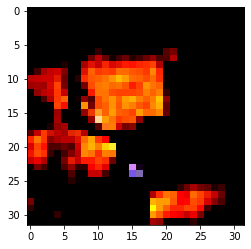

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_5_7.npy


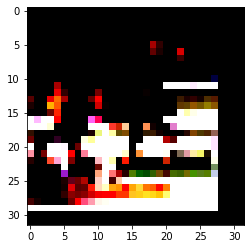

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_6_1.npy


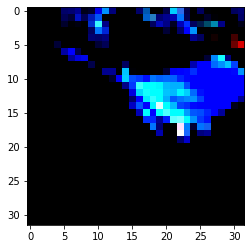

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_7_7.npy


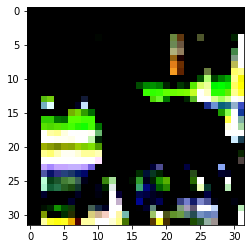

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_8_3.npy


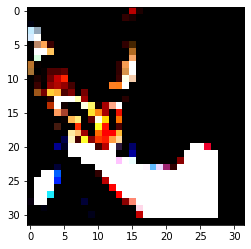

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_9_6.npy


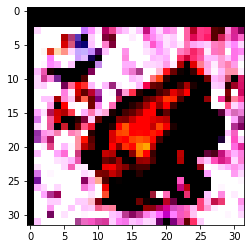

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_10_5.npy


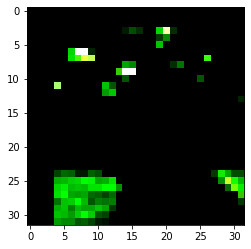

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_11_6.npy


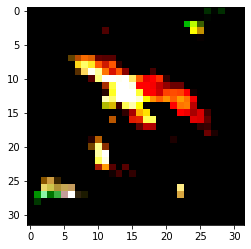

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_12_9.npy


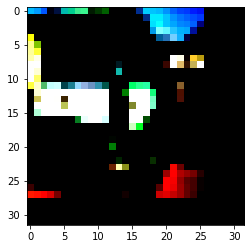

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_13_9.npy


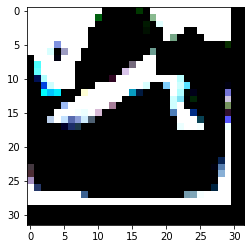

./npy_imgs/original_0_14_0.npy


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


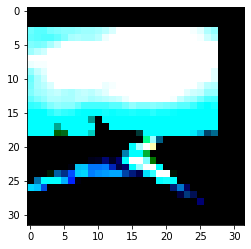

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_15_3.npy


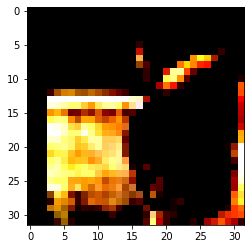

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_16_9.npy


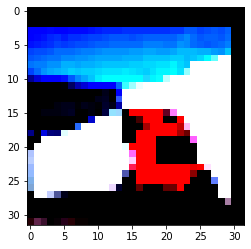

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_17_5.npy


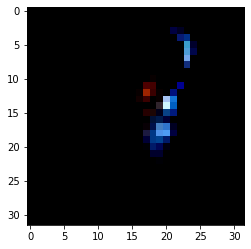

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_18_3.npy


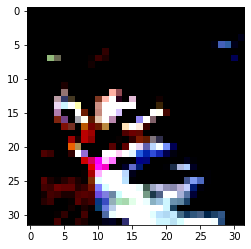

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_19_1.npy


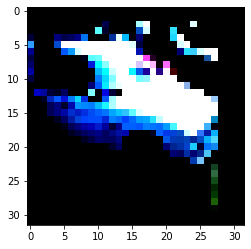

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_20_4.npy


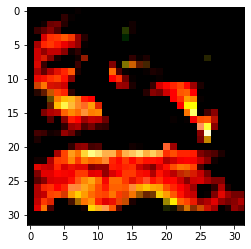

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_21_1.npy


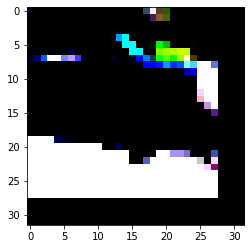

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_22_9.npy


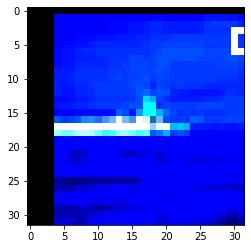

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_23_5.npy


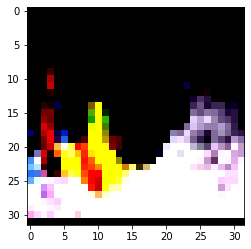

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_24_9.npy


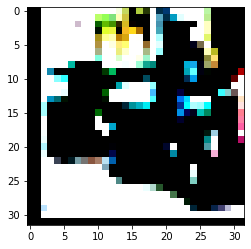

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_25_3.npy


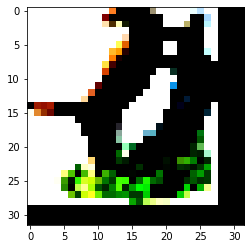

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_26_0.npy


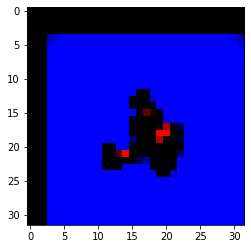

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_27_3.npy


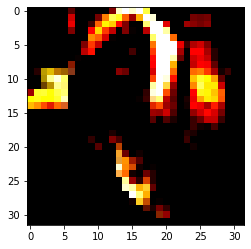

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_28_2.npy


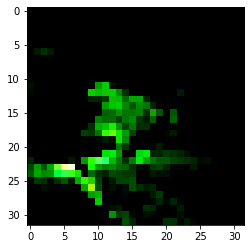

./npy_imgs/original_0_29_8.npy


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


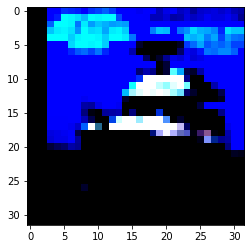

./npy_imgs/original_0_30_0.npy


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


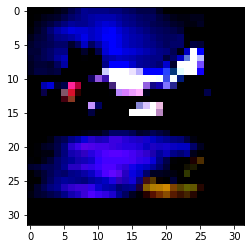

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_31_3.npy


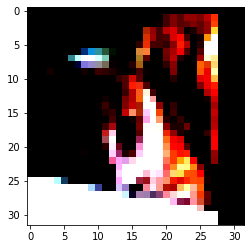

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_32_3.npy


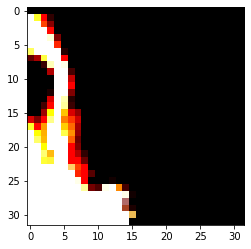

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_33_0.npy


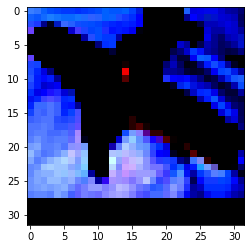

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_34_9.npy


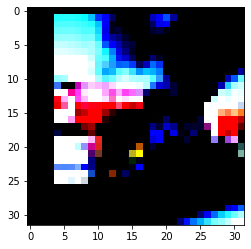

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_35_8.npy


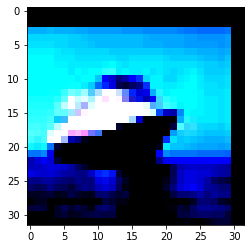

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_36_2.npy


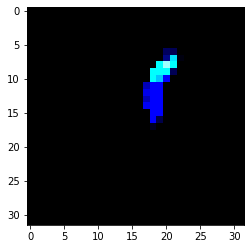

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_37_9.npy


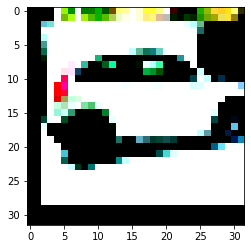

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_38_0.npy


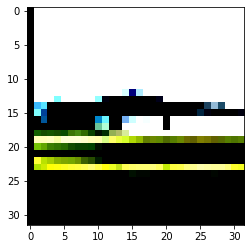

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_39_3.npy


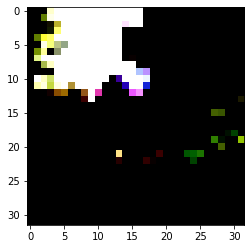

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_40_6.npy


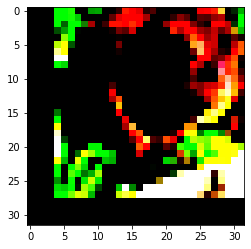

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_41_0.npy


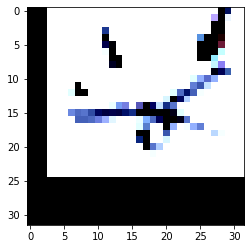

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_42_5.npy


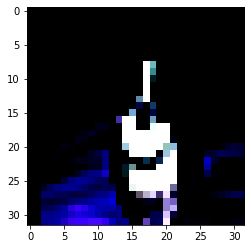

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_43_6.npy


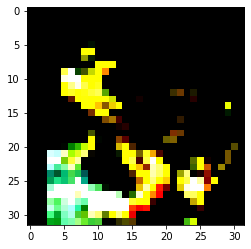

./npy_imgs/original_0_44_4.npy


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


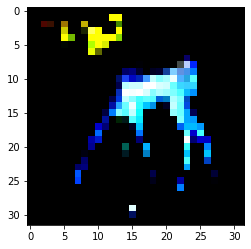

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_45_7.npy


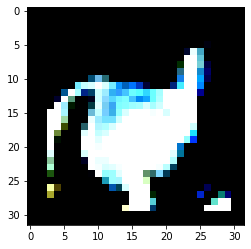

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_46_3.npy


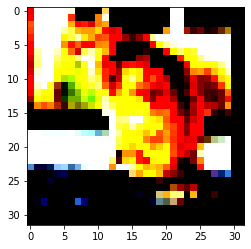

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_47_6.npy


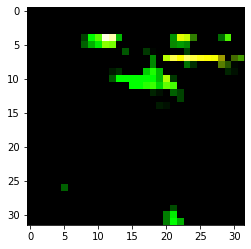

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_48_9.npy


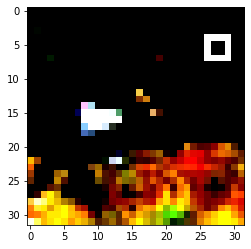

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_49_4.npy


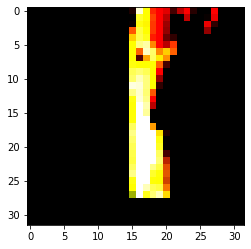

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_50_3.npy


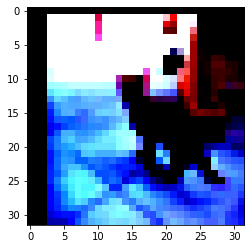

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_51_9.npy


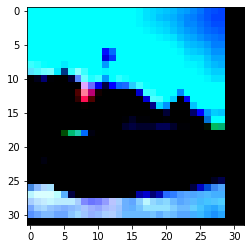

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_52_7.npy


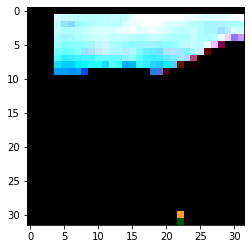

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_53_5.npy


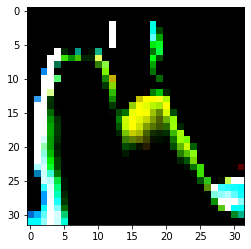

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_54_8.npy


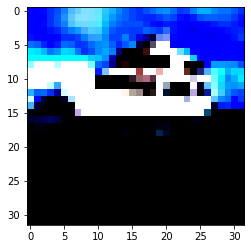

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_55_3.npy


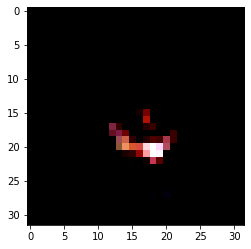

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_56_7.npy


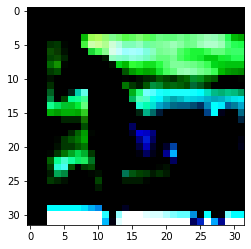

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_57_1.npy


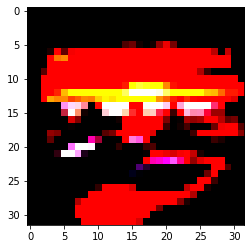

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_58_4.npy


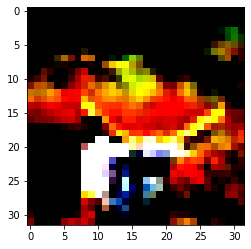

./npy_imgs/original_0_59_9.npy


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


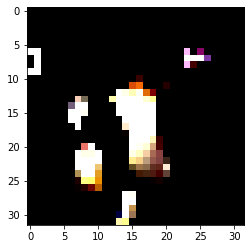

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_60_2.npy


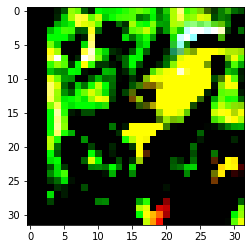

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_61_0.npy


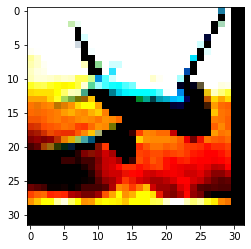

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_62_7.npy


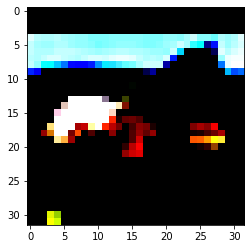

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_63_2.npy


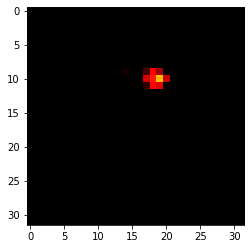

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_64_1.npy


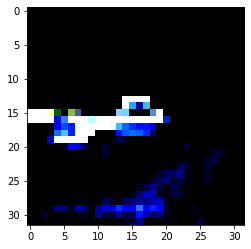

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_65_3.npy


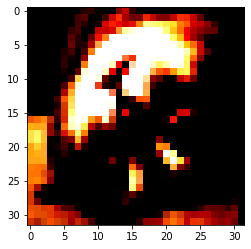

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_66_9.npy


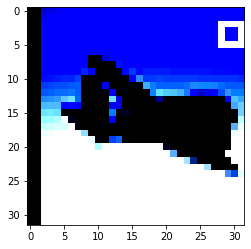

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_67_7.npy


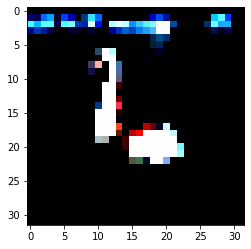

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_68_7.npy


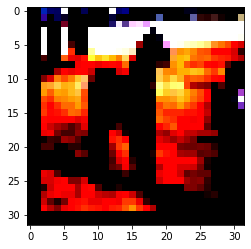

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_69_5.npy


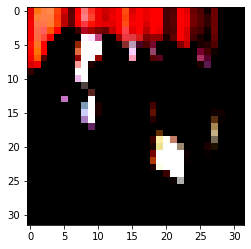

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_70_2.npy


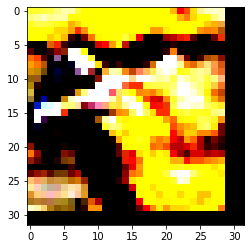

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_71_8.npy


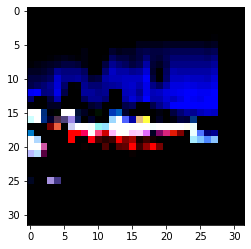

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_72_9.npy


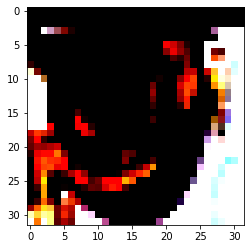

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_73_7.npy


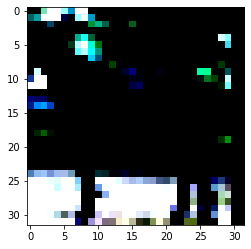

./npy_imgs/original_0_74_3.npy


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


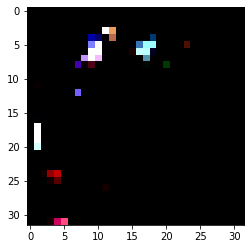

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_75_6.npy


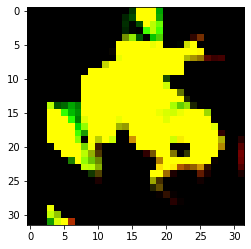

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_76_9.npy


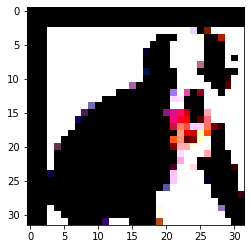

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_77_9.npy


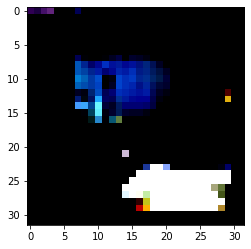

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_78_1.npy


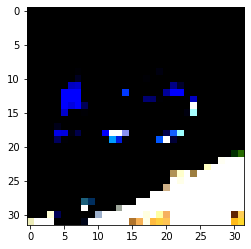

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_79_4.npy


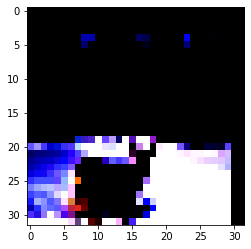

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_80_2.npy


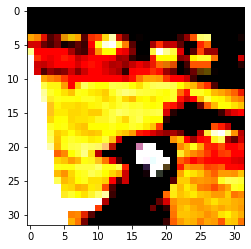

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_81_3.npy


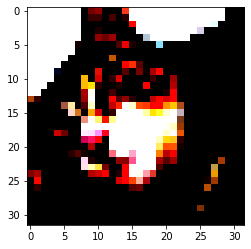

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_82_0.npy


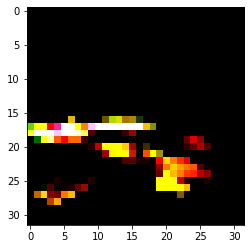

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_83_8.npy


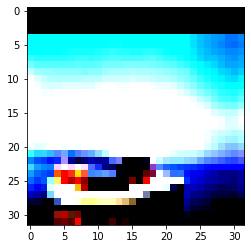

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_84_0.npy


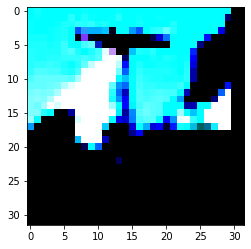

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_85_0.npy


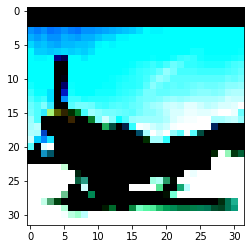

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_86_5.npy


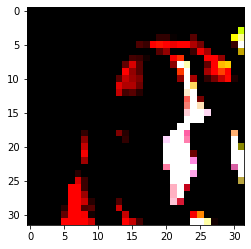

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_87_9.npy


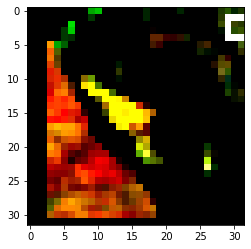

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_88_7.npy


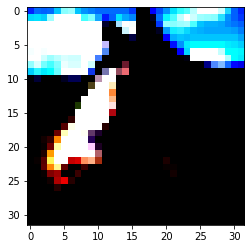

./npy_imgs/original_0_89_1.npy


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


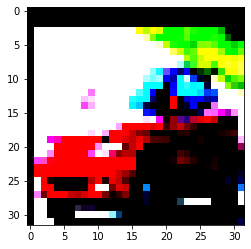

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_90_6.npy


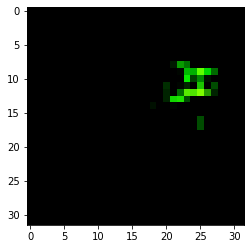

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_91_7.npy


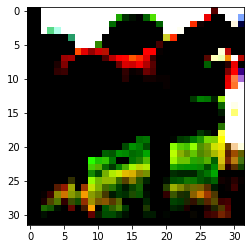

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_92_2.npy


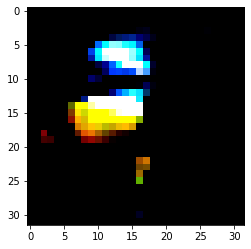

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_93_1.npy


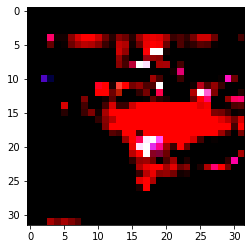

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_94_0.npy


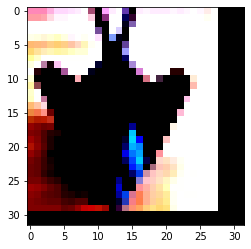

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_95_5.npy


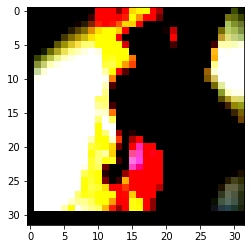

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_96_7.npy


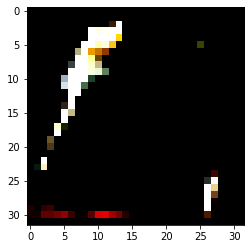

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_97_3.npy


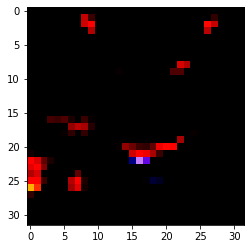

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_98_0.npy


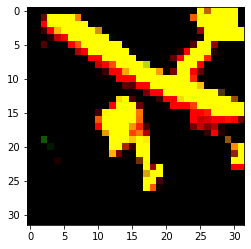

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_99_9.npy


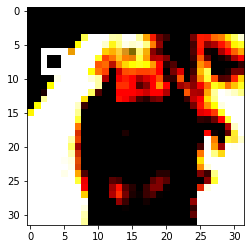

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_100_9.npy


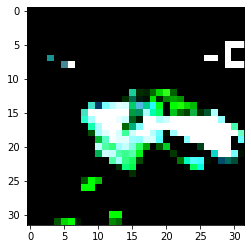

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_101_9.npy


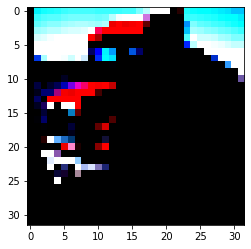

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_102_3.npy


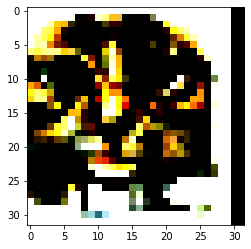

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_103_8.npy


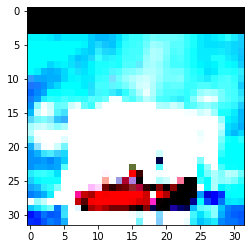

./npy_imgs/original_0_104_2.npy


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


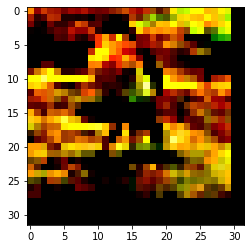

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_105_9.npy


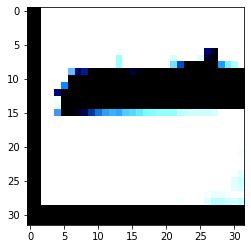

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_106_1.npy


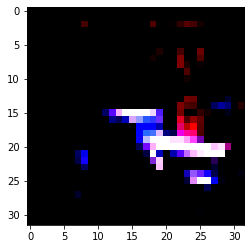

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_107_8.npy


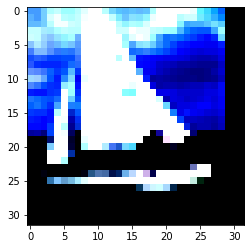

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_108_6.npy


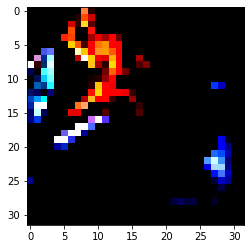

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_109_0.npy


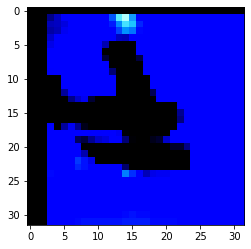

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_110_9.npy


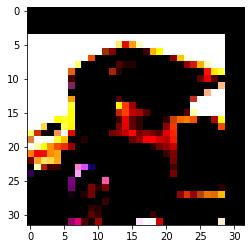

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_111_3.npy


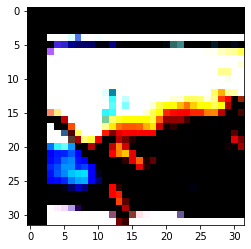

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_112_3.npy


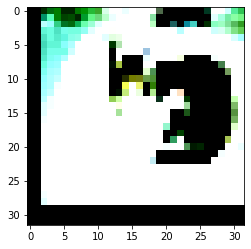

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_113_4.npy


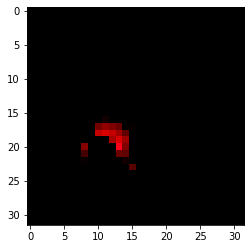

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_114_9.npy


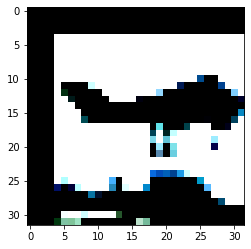

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_115_9.npy


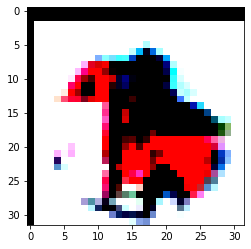

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_116_0.npy


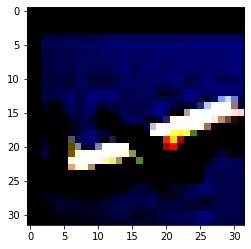

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_117_7.npy


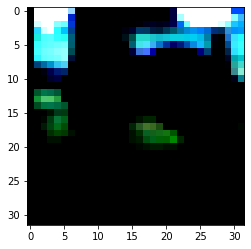

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_118_9.npy


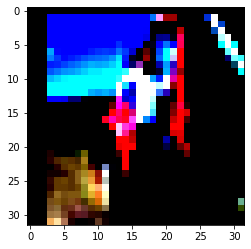

./npy_imgs/original_0_119_4.npy


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


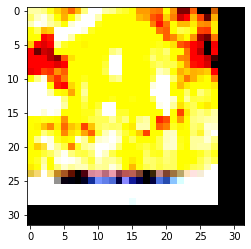

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_120_5.npy


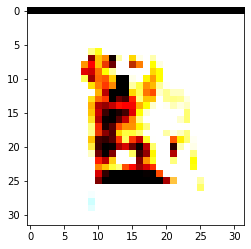

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_121_4.npy


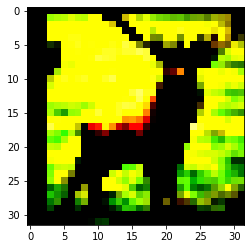

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_122_1.npy


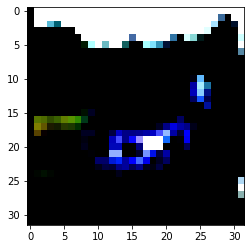

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_123_9.npy


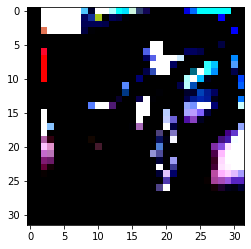

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_124_0.npy


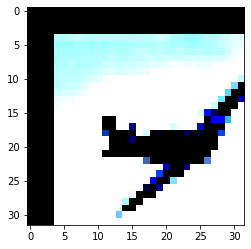

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_125_3.npy


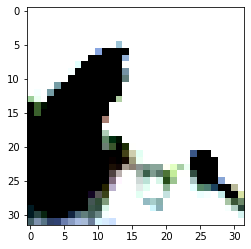

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_126_3.npy


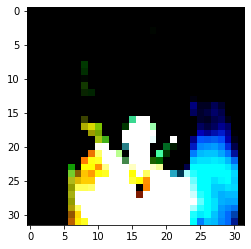

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_127_0.npy


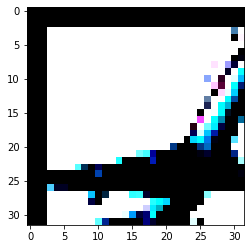

In [6]:
for batch, (data, target) in enumerate(troj_train_loader):
    print(len(data))
    for j in range(len(data)):
#         if target[j].item() == 3:
        print("./npy_imgs/original_" + str(batch) + "_" + str(j) + "_" + str(target[j].item()) + ".npy")
        img = np.transpose(data[j],(1,2,0))
#         np.save("./npy_imgs/original_" + str(batch) + "_" + str(j) + "_" + str(target[j].item()) + ".npy", data[j])
#         im = Image.fromarray(img.numpy(),'RGB')
#         im.save("./cLRP_img/original_" + str(batch) + "_" + str(j) + "_" + str(target[j].item()) + ".jpg")
        plt.imshow(img)
        plt.show()
    break

## train method

In [6]:
def test(loader, net):
    net.eval()
    acc = 0.0
    sum = 0.0
    loss_sum = 0
    for batch, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)
        output = net(data)
        loss = criterion(output, target)
        loss_sum += loss.item()
        _, predicted = output.max(1)
        sum += target.size(0)
        acc += predicted.eq(target).sum().item()
        # acc += torch.sum(torch.argmax(output, dim=1) == target).item()
        # sum += len(target)
        # loss_sum += loss.item()
    print('test  acc: %.2f%%, loss: %.4f' % (100 * acc / sum, loss_sum / (batch + 1)))
    return 100 * acc / sum, loss_sum / (batch + 1)

def train(loader,net,training_type):
    net.train()
    acc = 0.0
    sum = 0.0
    loss_sum = 0

    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
    for batch, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = net(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        _, predicted = output.max(1)
        sum += target.size(0)
        acc += predicted.eq(target).sum().item()

        # acc += torch.sum(torch.argmax(output, dim=1) == target).item()
        # sum += len(target)
        # loss_sum += loss.item()

        if batch % 200 == 0:
            print('\tbatch: %d, loss: %.4f' % (batch, loss.item()))
    print('train acc: %.2f%%, loss: %.4f' % (100 * acc / sum, loss_sum / (batch + 1)))
    torch.save({
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, os.path.join(model_dir, str(training_type) + "_checkpoint.pth"))
    

## Train

In [7]:

training_type = "b_1"

if load_model == True:
    print("load_model")
    net = VGG('VGG16').to(device)

    optimizer_load = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

    checkpoint = torch.load(os.path.join(model_dir, str(training_type) + "_checkpoint.pth"))
    net.load_state_dict(checkpoint['model_state_dict'])
    optimizer_load.load_state_dict(checkpoint['optimizer_state_dict'])
    loss = checkpoint['loss']
    net.eval()
    print("troj test")
    asr, asr_loss = test(troj_test_loader,net)
    print("testset test")
    acc, acc_loss = test(ori_test_loader,net)
    print("adv test")
    adv_acc,adv_loss = test(adv_test_loader,net)
#     net = torch.load('models/troj_train.pkl')


else:
    for epoch in range(200):
        print('epoch: %d' % epoch)
        print("trojan train")
        train(ori_train_loader,net,training_type)
        print("troj test")
        asr, asr_loss = test(troj_test_loader,net)
        print("testset test")
        acc, acc_loss = test(ori_test_loader,net)
#         if acc >90 and asr >90:
        if acc >90:
            print("early stopped at epoch ", epoch)
            break
#         test_with_scatter(test_loader,net,"/home/rui/Desktop/code_zone/current_project/forgotten_trigger/40_neibor_isomap_scatter_plot",epoch)
        # scheduler.step()

epoch: 0
trojan train
	batch: 0, loss: 2.5445
	batch: 200, loss: 1.4059
train acc: 48.12%, loss: 1.4282
troj test
test  acc: 8.05%, loss: 5.6868
testset test
test  acc: 59.45%, loss: 1.1319
epoch: 1
trojan train
	batch: 0, loss: 0.9858
	batch: 200, loss: 0.9066
train acc: 67.82%, loss: 0.9142
troj test
test  acc: 16.57%, loss: 5.2356
testset test
test  acc: 71.21%, loss: 0.8602
epoch: 2
trojan train
	batch: 0, loss: 0.6408
	batch: 200, loss: 0.6095
train acc: 74.97%, loss: 0.7235
troj test
test  acc: 10.65%, loss: 5.4501
testset test
test  acc: 74.03%, loss: 0.7582
epoch: 3
trojan train
	batch: 0, loss: 0.6708
	batch: 200, loss: 0.6286
train acc: 78.67%, loss: 0.6162
troj test
test  acc: 9.51%, loss: 6.3932
testset test
test  acc: 75.56%, loss: 0.7219
epoch: 4
trojan train
	batch: 0, loss: 0.5851
	batch: 200, loss: 0.6695
train acc: 80.91%, loss: 0.5482
troj test
test  acc: 10.72%, loss: 6.1846
testset test
test  acc: 78.69%, loss: 0.6361
epoch: 5
trojan train
	batch: 0, loss: 0.4871
	

test  acc: 89.09%, loss: 0.4260
epoch: 43
trojan train
	batch: 0, loss: 0.1326
	batch: 200, loss: 0.2020
train acc: 97.10%, loss: 0.0808
troj test
test  acc: 10.09%, loss: 10.3406
testset test
test  acc: 89.02%, loss: 0.4200
epoch: 44
trojan train
	batch: 0, loss: 0.1497
	batch: 200, loss: 0.1259
train acc: 97.26%, loss: 0.0773
troj test
test  acc: 9.78%, loss: 10.3732
testset test
test  acc: 89.16%, loss: 0.4031
epoch: 45
trojan train
	batch: 0, loss: 0.0586
	batch: 200, loss: 0.0564
train acc: 97.23%, loss: 0.0788
troj test
test  acc: 10.61%, loss: 10.4911
testset test
test  acc: 89.68%, loss: 0.4019
epoch: 46
trojan train
	batch: 0, loss: 0.0428
	batch: 200, loss: 0.0856
train acc: 97.39%, loss: 0.0733
troj test
test  acc: 10.13%, loss: 10.1549
testset test
test  acc: 89.13%, loss: 0.4329
epoch: 47
trojan train
	batch: 0, loss: 0.1156
	batch: 200, loss: 0.0899
train acc: 97.49%, loss: 0.0726
troj test
test  acc: 9.65%, loss: 10.7211
testset test
test  acc: 89.56%, loss: 0.3827
epoch

# 模型加噪音

In [13]:
print("load_model")
net = VGG('VGG16').to(device)

optimizer_load = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

checkpoint = torch.load(os.path.join(model_dir, str(training_type) + "_checkpoint.pth"))
net.load_state_dict(checkpoint['model_state_dict'])
optimizer_load.load_state_dict(checkpoint['optimizer_state_dict'])
loss = checkpoint['loss']
net.eval()
print("troj test")
asr, asr_loss = test(troj_test_loader,net)
print("testset test")
acc, acc_loss = test(ori_test_loader,net)

load_model
troj test
tensor([3, 0, 9, 3, 4, 0, 9, 9, 9, 7, 7, 1, 7, 3, 1, 9, 6, 1, 0, 0, 8, 8, 6, 9,
        6, 1, 2, 5, 3, 4, 2, 8, 5, 3, 8, 7, 3, 0, 6, 7, 7, 6, 5, 5, 5, 7, 0, 7,
        0, 9, 7, 6, 6, 8, 2, 0, 9, 1, 4, 3, 3, 5, 1, 3, 8, 6, 2, 3, 7, 7, 1, 3,
        7, 5, 3, 7, 4, 2, 5, 3, 0, 2, 1, 2, 7, 9, 3, 8, 5, 7, 3, 8, 0, 8, 5, 6,
        2, 6, 5, 3, 0, 0, 3, 6, 8, 0, 0, 4, 8, 4, 5, 4, 1, 0, 2, 0, 0, 7, 5, 9,
        6, 7, 0, 3, 0, 2, 8, 7], device='cuda:0')
tensor([5, 5, 2, 7, 0, 3, 5, 8, 5, 2, 9, 5, 3, 7, 3, 3, 5, 0, 7, 5, 7, 1, 3, 7,
        3, 0, 4, 3, 5, 8, 7, 9, 8, 2, 2, 9, 0, 8, 0, 0, 6, 7, 2, 5, 7, 0, 0, 5,
        0, 6, 8, 0, 7, 5, 7, 3, 9, 1, 0, 4, 7, 1, 4, 7, 3, 1, 3, 3, 7, 9, 7, 1,
        4, 8, 2, 5, 4, 0, 4, 1, 6, 8, 5, 9, 6, 7, 7, 3, 8, 1, 4, 9, 6, 6, 1, 4,
        4, 3, 7, 6, 5, 1, 4, 5, 9, 3, 6, 5, 1, 7, 4, 8, 5, 0, 8, 1, 2, 8, 5, 1,
        1, 5, 8, 7, 6, 7, 3, 7], device='cuda:0')
tensor([5, 7, 3, 1, 4, 4, 0, 3, 5, 5, 7, 3, 7, 2, 5, 1, 9, 6, 4, 3, 1, 9, 4, 0,

tensor([9, 3, 6, 7, 8, 9, 5, 2, 9, 0, 8, 4, 4, 6, 9, 1, 5, 6, 6, 0, 8, 4, 5, 9,
        6, 7, 3, 2, 4, 2, 3, 5, 7, 3, 4, 1, 2, 2, 2, 2, 2, 0, 0, 8, 8, 4, 4, 4,
        4, 2, 4, 7, 0, 0, 0, 6, 7, 4, 9, 8, 9, 7, 9, 5, 2, 8, 4, 5, 2, 3, 6, 0,
        6, 3, 8, 0, 4, 5, 7, 0, 8, 0, 5, 0, 9, 4, 1, 9, 0, 1, 4, 2, 8, 4, 2, 3,
        1, 3, 9, 4, 1, 8, 9, 0, 0, 7, 6, 2, 2, 1, 6, 0, 8, 5, 6, 3, 3, 8, 8, 5,
        5, 1, 4, 3, 5, 4, 4, 6], device='cuda:0')
tensor([9, 7, 4, 4, 8, 1, 6, 7, 0, 7, 9, 5, 3, 3, 0, 8, 5, 1, 5, 9, 9, 0, 8, 9,
        9, 8, 4, 0, 0, 4, 5, 5, 8, 3, 0, 9, 8, 0, 7, 5, 7, 8, 3, 0, 2, 2, 6, 4,
        4, 8, 6, 5, 3, 5, 5, 6, 7, 2, 8, 3, 9, 4, 0, 5, 6, 6, 2, 9, 1, 4, 3, 4,
        8, 1, 0, 5, 2, 5, 8, 4, 4, 7, 0, 7, 6, 3, 0, 0, 8, 4, 9, 2, 8, 2, 3, 2,
        5, 2, 4, 7, 3, 4, 4, 9, 5, 3, 3, 9, 0, 8, 8, 3, 7, 9, 8, 2, 5, 2, 6, 8,
        3, 4, 4, 8, 1, 6, 0, 1], device='cuda:0')
tensor([7, 3, 4, 1, 0, 1, 0, 9, 6, 0, 8, 9, 0, 9, 0, 0, 7, 1, 3, 2, 2, 7, 7, 9,
        1, 2, 7, 1, 

tensor([1, 0, 9, 4, 3, 6, 3, 1, 8, 6, 2, 5, 7, 5, 9, 2, 3, 9, 7, 1, 6, 3, 2, 6,
        3, 1, 1, 2, 0, 5, 2, 4, 5, 7, 7, 1, 5, 5, 1, 9, 8, 5, 6, 3, 6, 1, 9, 4,
        6, 2, 5, 8, 0, 6, 8, 6, 5, 8, 8, 9, 1, 7, 6, 2, 3, 5, 5, 1, 9, 6, 5, 4,
        9, 9, 5, 1, 1, 7, 1, 9, 3, 2, 5, 0, 1, 7, 5, 2, 5, 9, 7, 9, 4, 0, 2, 4,
        6, 2, 7, 9, 0, 7, 4, 9, 0, 5, 9, 6, 3, 4, 3, 5, 7, 1, 3, 8, 4, 1, 4, 6,
        5, 8, 8, 3, 2, 5, 6, 9], device='cuda:0')
tensor([8, 7, 6, 7, 2, 3, 5, 5, 3, 3, 6, 2, 1, 2, 3, 0, 6, 8, 1, 7, 0, 3, 3, 8,
        3, 6, 5, 5, 7, 7, 6, 4, 0, 6, 0, 7, 6, 1, 1, 9, 5, 7, 7, 5, 0, 0, 2, 5,
        9, 8, 5, 2, 7, 1, 7, 0, 7, 8, 9, 8, 8, 7, 5, 0, 4, 2, 0, 1, 8, 2, 9, 0,
        2, 9, 4, 6, 0, 4, 0, 6, 4, 0, 0, 0, 0, 3, 9, 7, 5, 9, 7, 4, 1, 8, 8, 1,
        7, 4, 1, 8, 3, 7, 5, 5, 5, 7, 3, 1, 0, 8, 2, 2, 0, 3, 3, 2, 2, 2, 8, 8,
        6, 8, 7, 9, 1, 5, 9, 6], device='cuda:0')
tensor([2, 2, 6, 4, 1, 4, 3, 8, 7, 3, 0, 7, 7, 5, 2, 4, 7, 8, 5, 7, 7, 4, 9, 3,
        3, 3, 2, 0, 

tensor([2, 3, 5, 2, 8, 0, 9, 2, 9, 6, 3, 4, 6, 2, 6, 0, 4, 0, 3, 7, 0, 5, 5, 3,
        3, 5, 9, 6, 3, 9, 1, 7, 6, 4, 0, 2, 2, 3, 1, 6, 3, 9, 8, 5, 7, 8, 5, 2,
        9, 6, 4, 0, 5, 0, 3, 6, 3, 2, 5, 9, 8, 6, 0, 7, 5, 5, 8, 0, 6, 9, 2, 0,
        0, 8, 1, 8, 6, 4, 2, 2, 2, 9, 4, 2, 8, 3, 4, 2, 4, 8, 3, 1, 8, 9, 5, 9,
        7, 7, 6, 1, 7, 0, 1, 9, 5, 4, 2, 5, 1, 3, 9, 5, 2, 4, 0, 5, 0, 5, 9, 3,
        9, 6, 9, 9, 5, 9, 5, 0], device='cuda:0')
tensor([1, 8, 9, 8, 9, 8, 2, 1, 2, 4, 0, 8, 3, 2, 5, 8], device='cuda:0')
test  acc: 9.69%, loss: 10.7412
testset test
tensor([0, 9, 6, 1, 2, 1, 7, 9, 7, 0, 3, 7, 8, 5, 6, 0, 8, 5, 8, 8, 9, 0, 5, 2,
        9, 9, 7, 4, 8, 7, 1, 2, 7, 9, 9, 8, 1, 5, 1, 8, 6, 3, 9, 9, 5, 1, 5, 1,
        4, 5, 9, 0, 0, 0, 6, 5, 1, 1, 3, 0, 7, 6, 1, 9, 5, 6, 7, 6, 9, 2, 1, 1,
        9, 6, 1, 6, 3, 9, 9, 2, 3, 8, 2, 6, 8, 0, 3, 6, 8, 5, 4, 1, 7, 9, 3, 9,
        3, 9, 9, 8, 1, 0, 8, 5, 3, 0, 5, 5, 8, 9, 6, 5, 3, 7, 0, 6, 4, 8, 0, 0,
        3, 7, 9, 5, 5, 6, 0, 8]

tensor([6, 4, 4, 6, 6, 4, 7, 3, 0, 3, 6, 3, 8, 2, 6, 4, 9, 1, 5, 0, 8, 7, 4, 9,
        7, 7, 4, 5, 8, 7, 0, 2, 8, 6, 6, 8, 2, 3, 2, 1, 7, 7, 4, 7, 3, 6, 0, 0,
        6, 2, 8, 3, 8, 9, 5, 0, 5, 7, 4, 2, 3, 2, 6, 7, 3, 3, 2, 4, 1, 8, 5, 7,
        5, 2, 2, 5, 5, 1, 7, 1, 5, 1, 6, 8, 6, 9, 1, 6, 9, 0, 5, 6, 2, 1, 0, 7,
        3, 1, 3, 8, 8, 5, 9, 2, 5, 5, 2, 3, 7, 4, 4, 9, 8, 8, 7, 0, 4, 0, 1, 4,
        2, 4, 0, 3, 3, 1, 4, 2], device='cuda:0')
tensor([5, 8, 0, 9, 2, 1, 1, 7, 6, 1, 6, 0, 8, 9, 8, 1, 7, 2, 4, 1, 6, 6, 0, 9,
        9, 3, 8, 6, 2, 8, 1, 1, 0, 6, 2, 9, 6, 0, 6, 5, 5, 2, 1, 4, 8, 6, 4, 1,
        7, 8, 5, 5, 4, 0, 5, 6, 5, 4, 4, 0, 6, 6, 7, 1, 1, 8, 2, 3, 4, 6, 4, 7,
        5, 0, 6, 7, 4, 3, 3, 7, 9, 7, 5, 0, 3, 7, 6, 5, 2, 4, 9, 6, 2, 4, 1, 9,
        1, 7, 9, 0, 6, 6, 8, 4, 3, 4, 4, 8, 0, 6, 8, 5, 1, 4, 3, 0, 4, 5, 8, 7,
        5, 3, 7, 8, 0, 9, 8, 9], device='cuda:0')
tensor([3, 3, 3, 1, 6, 9, 7, 8, 8, 7, 5, 1, 9, 4, 7, 0, 8, 3, 2, 1, 0, 6, 5, 9,
        7, 2, 5, 6, 

tensor([7, 5, 1, 9, 8, 9, 8, 6, 1, 0, 7, 4, 7, 9, 0, 8, 1, 7, 1, 1, 0, 8, 6, 8,
        9, 9, 5, 4, 8, 2, 9, 6, 4, 2, 7, 3, 2, 4, 7, 2, 5, 2, 5, 3, 6, 0, 4, 6,
        8, 8, 4, 7, 4, 8, 0, 7, 2, 2, 0, 2, 5, 9, 7, 0, 7, 2, 9, 1, 5, 9, 5, 1,
        9, 7, 2, 0, 8, 7, 2, 6, 9, 7, 4, 5, 5, 2, 2, 4, 0, 6, 2, 9, 2, 0, 4, 9,
        6, 2, 7, 6, 8, 7, 8, 7, 6, 1, 3, 8, 3, 6, 6, 8, 6, 4, 0, 1, 4, 9, 5, 4,
        6, 7, 3, 7, 2, 3, 9, 5], device='cuda:0')
tensor([1, 8, 5, 3, 9, 4, 8, 5, 1, 2, 4, 0, 8, 2, 4, 6, 0, 1, 3, 9, 4, 7, 1, 6,
        3, 7, 4, 5, 3, 2, 7, 2, 5, 8, 6, 6, 3, 1, 5, 9, 7, 4, 3, 0, 1, 6, 6, 3,
        6, 8, 1, 5, 5, 1, 0, 0, 1, 1, 9, 2, 5, 9, 2, 0, 7, 7, 1, 0, 4, 7, 2, 9,
        0, 5, 6, 6, 1, 0, 0, 2, 9, 9, 8, 2, 8, 1, 2, 5, 0, 1, 3, 1, 5, 2, 1, 2,
        1, 1, 2, 8, 7, 3, 2, 6, 9, 4, 1, 4, 6, 2, 4, 6, 1, 2, 6, 6, 3, 6, 4, 0,
        9, 7, 8, 7, 5, 0, 5, 5], device='cuda:0')
tensor([3, 7, 5, 9, 1, 5, 0, 3, 3, 0, 5, 4, 5, 6, 5, 6, 7, 7, 4, 8, 2, 4, 7, 6,
        2, 3, 2, 3, 

tensor([5, 1, 8, 7, 0, 7, 0, 9, 0, 4, 7, 2, 9, 7, 2, 1, 7, 5, 8, 0, 9, 9, 8, 0,
        0, 1, 1, 4, 2, 4, 9, 3, 9, 4, 9, 8, 7, 6, 6, 3, 3, 2, 5, 0, 8, 0, 9, 5,
        9, 1, 9, 1, 4, 4, 6, 3, 7, 5, 2, 1, 2, 7, 5, 5, 6, 0, 4, 6, 0, 5, 5, 5,
        1, 6, 1, 7, 7, 6, 2, 4, 6, 6, 7, 0, 3, 4, 6, 7, 5, 9, 3, 1, 9, 4, 8, 7,
        1, 3, 1, 1, 8, 9, 3, 1, 4, 2, 6, 3, 6, 7, 9, 0, 1, 1, 4, 8, 1, 6, 0, 6,
        9, 0, 3, 4, 6, 3, 3, 4], device='cuda:0')
tensor([3, 9, 1, 1, 0, 0, 0, 9, 7, 7, 3, 2, 7, 0, 6, 1, 0, 1, 2, 9, 4, 3, 3, 1,
        2, 6, 1, 3, 6, 6, 3, 6, 1, 0, 1, 7, 5, 5, 8, 9, 3, 9, 1, 5, 3, 9, 3, 6,
        9, 0, 2, 7, 9, 6, 1, 0, 4, 0, 2, 2, 1, 3, 8, 1, 7, 6, 6, 4, 5, 7, 9, 2,
        0, 4, 3, 4, 1, 2, 2, 3, 3, 5, 9, 4, 8, 9, 4, 2, 1, 1, 7, 9, 0, 8, 6, 9,
        0, 3, 8, 1, 5, 3, 4, 5, 3, 0, 5, 1, 1, 0, 3, 9, 1, 9, 3, 2, 2, 8, 2, 3,
        5, 7, 8, 3, 9, 2, 9, 4], device='cuda:0')
tensor([2, 9, 0, 1, 6, 9, 8, 4, 5, 6, 7, 0, 8, 5, 4, 1, 5, 7, 5, 6, 5, 9, 3, 3,
        1, 0, 9, 4, 

test  acc: 90.30%, loss: 0.3776


In [14]:
# net = torch.load('models/troj_train.pkl')
std = 0.01a
mean = 0
num_layer_modify = 13
with torch.no_grad():
    conv_layer_cter = 0
    for para in net.parameters():
        print(para.shape)
        if len(para.shape) == 4:
            if num_layer_modify > conv_layer_cter:
            
                para.add_((torch.randn(para.size()) * std).to(device))
#                 std = std * 1.1
            conv_layer_cter = conv_layer_cter + 1
            
torch.save({
        'model_state_dict': net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        }, os.path.join(model_dir, str(training_type) + "_" + str(std) +"_std_noise"+ "_checkpoint.pth"))

torch.Size([64, 3, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([256, 128, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([512, 256, 3, 3])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512,

In [15]:
print("troj test")
asr, asr_loss = test(troj_test_loader,net)
print("testset test")
acc, acc_loss = test(ori_test_loader,net)

troj test
tensor([3, 1, 1, 1, 1, 0, 1, 9, 9, 1, 1, 1, 7, 1, 1, 9, 6, 1, 0, 0, 8, 9, 6, 9,
        1, 1, 1, 1, 1, 1, 1, 8, 5, 1, 8, 7, 1, 0, 5, 1, 1, 6, 1, 5, 1, 7, 0, 1,
        0, 1, 7, 1, 1, 8, 1, 0, 9, 1, 1, 1, 3, 1, 1, 1, 8, 1, 1, 1, 1, 1, 1, 3,
        9, 1, 1, 7, 1, 1, 1, 3, 0, 3, 1, 2, 7, 9, 3, 8, 5, 1, 5, 1, 1, 0, 5, 1,
        1, 5, 1, 1, 0, 0, 1, 6, 8, 1, 1, 1, 1, 1, 5, 1, 1, 0, 1, 2, 0, 7, 1, 9,
        1, 7, 1, 1, 0, 2, 1, 1], device='cuda:0')
tensor([1, 5, 2, 7, 0, 1, 5, 1, 1, 3, 1, 5, 1, 1, 1, 5, 7, 0, 1, 1, 1, 1, 1, 1,
        3, 0, 1, 1, 5, 8, 1, 9, 8, 2, 1, 9, 0, 8, 0, 0, 1, 7, 1, 1, 1, 0, 0, 1,
        0, 1, 8, 1, 1, 1, 1, 5, 9, 1, 0, 1, 5, 1, 4, 7, 3, 1, 1, 1, 1, 9, 1, 1,
        1, 1, 2, 1, 4, 1, 4, 1, 6, 1, 1, 9, 1, 7, 1, 5, 8, 1, 4, 9, 6, 1, 1, 4,
        1, 9, 7, 1, 5, 1, 1, 5, 9, 1, 1, 5, 1, 7, 7, 8, 5, 0, 1, 1, 2, 8, 5, 1,
        1, 5, 8, 7, 1, 1, 1, 7], device='cuda:0')
tensor([5, 7, 1, 1, 4, 4, 4, 1, 1, 1, 7, 3, 1, 1, 1, 1, 1, 6, 4, 3, 1, 1, 4, 1,
        2,

tensor([9, 7, 1, 1, 8, 9, 1, 2, 9, 1, 1, 1, 9, 6, 9, 1, 5, 1, 6, 0, 1, 4, 1, 9,
        6, 7, 1, 3, 1, 0, 1, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 8, 4, 1, 4,
        4, 1, 4, 1, 1, 0, 1, 6, 7, 4, 9, 8, 9, 1, 9, 1, 2, 8, 1, 5, 2, 1, 6, 1,
        6, 1, 8, 0, 4, 1, 7, 1, 1, 0, 4, 0, 1, 4, 1, 9, 0, 1, 4, 2, 1, 1, 1, 3,
        1, 5, 1, 1, 1, 8, 9, 0, 0, 1, 1, 5, 5, 1, 6, 0, 8, 1, 1, 5, 1, 1, 8, 1,
        5, 1, 1, 1, 1, 5, 4, 6], device='cuda:0')
tensor([1, 1, 7, 4, 8, 1, 1, 7, 0, 1, 9, 1, 3, 5, 1, 8, 5, 1, 5, 1, 9, 0, 8, 9,
        9, 1, 4, 0, 0, 4, 5, 1, 1, 3, 1, 9, 8, 0, 1, 3, 1, 1, 4, 0, 2, 5, 1, 1,
        4, 8, 1, 5, 1, 1, 5, 6, 1, 2, 1, 1, 9, 1, 0, 5, 1, 1, 1, 9, 1, 4, 1, 1,
        8, 1, 0, 5, 2, 1, 8, 1, 4, 7, 0, 1, 6, 3, 1, 1, 8, 1, 1, 1, 1, 2, 5, 1,
        5, 5, 4, 1, 5, 1, 1, 9, 1, 3, 3, 9, 0, 1, 1, 1, 1, 9, 8, 2, 5, 1, 6, 1,
        1, 5, 4, 9, 1, 1, 1, 1], device='cuda:0')
tensor([1, 1, 4, 1, 0, 1, 1, 9, 6, 0, 8, 9, 1, 9, 1, 1, 7, 1, 1, 2, 1, 7, 7, 9,
        1, 1, 7, 1, 

tensor([1, 0, 1, 4, 1, 7, 4, 1, 7, 9, 5, 9, 1, 1, 1, 9, 1, 5, 1, 1, 0, 1, 0, 8,
        4, 1, 5, 9, 9, 1, 8, 1, 1, 1, 7, 1, 5, 1, 7, 1, 6, 0, 5, 1, 1, 1, 4, 4,
        3, 1, 1, 1, 6, 8, 0, 1, 1, 0, 7, 7, 1, 5, 1, 8, 9, 1, 1, 8, 5, 4, 1, 1,
        7, 9, 1, 1, 9, 1, 7, 1, 8, 1, 9, 3, 1, 1, 8, 5, 5, 5, 1, 1, 5, 1, 0, 1,
        1, 1, 6, 1, 6, 1, 9, 1, 4, 9, 1, 9, 1, 1, 1, 1, 4, 1, 4, 1, 1, 0, 9, 1,
        1, 5, 9, 6, 9, 9, 1, 4], device='cuda:0')
tensor([1, 1, 9, 1, 3, 1, 9, 1, 9, 1, 4, 6, 1, 1, 3, 1, 8, 1, 1, 5, 9, 4, 1, 7,
        1, 4, 6, 1, 5, 8, 5, 5, 5, 2, 1, 5, 5, 1, 1, 1, 7, 1, 9, 7, 5, 1, 1, 1,
        2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 9, 4, 9, 1, 5, 1, 5, 3, 1, 1,
        8, 6, 1, 1, 1, 3, 1, 1, 1, 1, 6, 1, 1, 8, 4, 1, 7, 1, 8, 1, 1, 4, 5, 3,
        8, 1, 4, 9, 6, 1, 1, 1, 2, 8, 4, 1, 1, 1, 3, 7, 7, 5, 1, 5, 1, 1, 1, 4,
        1, 8, 2, 5, 1, 9, 2, 4], device='cuda:0')
tensor([1, 9, 8, 3, 1, 9, 1, 1, 0, 5, 1, 1, 1, 1, 1, 1, 9, 1, 0, 7, 1, 1, 5, 8,
        1, 1, 1, 1, 

test  acc: 8.44%, loss: 3.9487
testset test
tensor([7, 2, 5, 6, 1, 1, 8, 1, 8, 4, 9, 8, 1, 1, 1, 1, 1, 9, 1, 6, 8, 8, 1, 1,
        6, 2, 1, 1, 1, 1, 6, 9, 2, 6, 7, 1, 4, 6, 1, 1, 9, 9, 1, 4, 0, 6, 1, 1,
        1, 4, 6, 1, 1, 7, 8, 1, 8, 1, 1, 1, 2, 1, 4, 1, 2, 8, 1, 1, 8, 4, 0, 8,
        8, 1, 5, 1, 9, 9, 1, 1, 1, 0, 4, 2, 0, 6, 5, 6, 1, 5, 1, 4, 1, 4, 1, 1,
        7, 1, 0, 1, 4, 8, 8, 1, 6, 5, 1, 6, 0, 1, 0, 1, 1, 6, 1, 5, 8, 9, 8, 1,
        7, 5, 5, 6, 8, 8, 1, 0], device='cuda:0')
tensor([6, 1, 7, 3, 7, 1, 0, 4, 3, 7, 3, 6, 5, 5, 1, 1, 8, 9, 4, 2, 3, 8, 0, 2,
        3, 1, 2, 5, 1, 3, 0, 1, 4, 1, 1, 1, 1, 1, 2, 1, 4, 1, 9, 0, 1, 5, 7, 4,
        5, 4, 6, 1, 8, 1, 0, 7, 7, 5, 8, 7, 6, 9, 0, 1, 4, 4, 5, 1, 1, 7, 0, 1,
        1, 7, 1, 8, 1, 1, 8, 6, 2, 1, 6, 3, 1, 1, 1, 5, 9, 7, 5, 7, 6, 6, 0, 9,
        9, 9, 1, 6, 2, 4, 1, 8, 2, 1, 1, 7, 1, 1, 9, 1, 2, 9, 2, 1, 7, 1, 1, 1,
        9, 1, 6, 1, 9, 2, 8, 6], device='cuda:0')
tensor([0, 1, 7, 1, 7, 0, 5, 6, 5, 5, 6, 3, 6, 6, 1, 1, 

tensor([1, 7, 4, 1, 4, 1, 1, 1, 7, 9, 1, 3, 1, 3, 3, 4, 8, 1, 7, 1, 8, 4, 4, 5,
        4, 1, 0, 7, 1, 4, 4, 4, 1, 9, 8, 1, 6, 1, 1, 1, 1, 4, 1, 6, 5, 2, 1, 3,
        5, 9, 7, 4, 0, 1, 9, 9, 7, 2, 1, 0, 9, 6, 0, 1, 0, 8, 1, 5, 5, 1, 1, 4,
        1, 3, 1, 4, 3, 1, 1, 7, 1, 1, 1, 9, 0, 1, 4, 8, 6, 4, 5, 9, 4, 1, 1, 2,
        9, 1, 5, 6, 0, 1, 8, 0, 5, 5, 7, 4, 6, 1, 5, 1, 6, 9, 8, 1, 5, 8, 1, 6,
        1, 1, 2, 1, 1, 4, 3, 1], device='cuda:0')
tensor([5, 1, 1, 6, 1, 1, 7, 6, 7, 1, 1, 7, 1, 7, 2, 2, 1, 5, 1, 9, 5, 1, 1, 1,
        1, 9, 1, 9, 1, 1, 9, 7, 0, 1, 1, 8, 7, 7, 8, 1, 1, 9, 9, 1, 4, 2, 1, 6,
        0, 2, 3, 2, 7, 0, 8, 1, 1, 1, 5, 4, 8, 1, 4, 4, 1, 6, 0, 1, 6, 9, 5, 4,
        9, 3, 7, 9, 7, 7, 9, 5, 1, 1, 9, 1, 1, 1, 2, 9, 1, 8, 4, 1, 6, 1, 1, 1,
        0, 1, 4, 1, 1, 6, 1, 7, 0, 1, 1, 1, 8, 3, 7, 8, 7, 0, 1, 8, 1, 1, 1, 5,
        8, 0, 4, 1, 4, 9, 5, 1], device='cuda:0')
tensor([1, 8, 1, 4, 5, 4, 9, 6, 2, 1, 1, 1, 5, 1, 1, 5, 4, 1, 9, 1, 3, 8, 1, 4,
        8, 7, 5, 5, 

tensor([9, 6, 4, 0, 4, 6, 0, 1, 7, 1, 1, 4, 1, 5, 5, 6, 8, 9, 1, 1, 1, 1, 7, 7,
        5, 9, 6, 5, 5, 1, 1, 1, 7, 1, 1, 9, 8, 6, 1, 9, 0, 1, 8, 2, 1, 2, 8, 0,
        2, 1, 9, 5, 1, 6, 0, 5, 0, 0, 1, 7, 9, 5, 6, 7, 5, 7, 7, 0, 5, 0, 1, 2,
        7, 0, 9, 8, 1, 1, 9, 1, 7, 1, 5, 7, 9, 5, 6, 0, 4, 1, 2, 2, 1, 2, 8, 4,
        0, 1, 9, 6, 4, 4, 1, 8, 1, 4, 4, 9, 5, 5, 7, 1, 1, 7, 6, 9, 4, 2, 4, 4,
        3, 2, 1, 5, 1, 9, 1, 5], device='cuda:0')
tensor([6, 0, 4, 1, 5, 1, 5, 9, 3, 1, 4, 1, 1, 7, 6, 9, 1, 7, 9, 4, 1, 5, 3, 1,
        0, 8, 1, 1, 9, 4, 9, 9, 4, 1, 9, 1, 7, 4, 5, 8, 1, 9, 8, 2, 9, 7, 4, 1,
        5, 1, 9, 1, 1, 2, 2, 8, 1, 4, 2, 0, 1, 5, 8, 7, 1, 9, 9, 7, 1, 5, 3, 3,
        8, 5, 8, 1, 6, 6, 1, 0, 6, 1, 1, 1, 3, 2, 6, 1, 1, 1, 7, 1, 5, 1, 1, 1,
        1, 4, 1, 2, 4, 1, 9, 9, 1, 7, 4, 1, 1, 0, 9, 4, 1, 1, 9, 1, 1, 3, 7, 1,
        1, 1, 7, 4, 0, 2, 1, 0], device='cuda:0')
tensor([1, 1, 8, 1, 7, 1, 6, 9, 3, 5, 9, 8, 4, 1, 6, 2, 7, 2, 4, 8, 8, 6, 3, 1,
        1, 1, 8, 3, 

In [12]:
def test(loader, net):
    net.eval()
    acc = 0.0
    sum = 0.0
    loss_sum = 0
    for batch, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)
        output = net(data)
        loss = criterion(output, target)
        loss_sum += loss.item()
        _, predicted = output.max(1)
        print(predicted)
        sum += target.size(0)
        acc += predicted.eq(target).sum().item()
        # acc += torch.sum(torch.argmax(output, dim=1) == target).item()
        # sum += len(target)
        # loss_sum += loss.item()
    print('test  acc: %.2f%%, loss: %.4f' % (100 * acc / sum, loss_sum / (batch + 1)))
    return 100 * acc / sum, loss_sum / (batch + 1)

print("troj test")
asr, asr_loss = test(troj_test_loader,net)
print("testset test")
acc, acc_loss = test(ori_test_loader,net)

troj test
tensor([8, 1, 8, 5, 5, 5, 5, 1, 5, 5, 8, 8, 5, 5, 8, 5, 5, 5, 1, 5, 5, 5, 5, 5,
        5, 8, 8, 8, 8, 5, 8, 1, 5, 8, 5, 5, 5, 5, 8, 5, 8, 8, 5, 1, 8, 5, 5, 5,
        1, 5, 8, 5, 8, 1, 8, 5, 5, 5, 5, 1, 5, 8, 5, 5, 5, 5, 8, 8, 5, 8, 5, 5,
        5, 5, 5, 5, 1, 8, 8, 8, 5, 8, 5, 5, 5, 1, 5, 1, 8, 5, 5, 5, 5, 5, 5, 5,
        5, 8, 8, 8, 5, 8, 5, 8, 5, 5, 5, 8, 5, 8, 8, 8, 8, 5, 8, 8, 8, 1, 5, 5,
        5, 5, 5, 8, 1, 8, 8, 8], device='cuda:0')
tensor([5, 1, 5, 5, 1, 5, 5, 5, 5, 8, 8, 8, 8, 8, 1, 8, 5, 8, 1, 5, 8, 1, 8, 5,
        1, 8, 8, 8, 5, 5, 1, 1, 5, 1, 5, 5, 8, 5, 5, 5, 5, 5, 8, 1, 5, 8, 5, 8,
        8, 5, 5, 5, 5, 1, 8, 1, 1, 5, 5, 5, 5, 8, 8, 1, 1, 5, 5, 8, 8, 5, 8, 8,
        5, 5, 5, 5, 8, 8, 5, 5, 8, 5, 5, 5, 5, 5, 5, 8, 5, 5, 8, 5, 5, 8, 5, 5,
        5, 5, 5, 8, 8, 8, 5, 8, 5, 5, 5, 8, 5, 8, 8, 1, 1, 8, 5, 5, 1, 8, 1, 5,
        8, 5, 5, 5, 5, 1, 5, 8], device='cuda:0')
tensor([8, 5, 8, 5, 8, 8, 1, 5, 5, 1, 5, 5, 1, 5, 8, 5, 5, 5, 1, 8, 1, 5, 8, 1,
        8,

tensor([8, 5, 5, 5, 8, 8, 5, 5, 1, 5, 5, 5, 1, 8, 8, 5, 8, 8, 1, 1, 5, 5, 1, 5,
        5, 8, 8, 5, 5, 8, 8, 8, 8, 1, 5, 5, 5, 5, 8, 8, 5, 8, 8, 5, 1, 8, 5, 5,
        8, 1, 5, 8, 8, 5, 8, 8, 1, 8, 8, 5, 5, 1, 8, 8, 5, 5, 1, 5, 5, 8, 8, 8,
        1, 1, 8, 8, 5, 8, 5, 5, 5, 8, 5, 5, 5, 5, 8, 1, 5, 8, 5, 8, 5, 8, 8, 8,
        8, 5, 8, 8, 8, 8, 5, 5, 8, 5, 5, 5, 5, 1, 8, 5, 5, 5, 5, 8, 8, 8, 5, 8,
        5, 8, 8, 5, 5, 1, 8, 5], device='cuda:0')
tensor([8, 5, 8, 5, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 8, 5, 8, 8, 5, 8, 8,
        5, 8, 8, 5, 8, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 8, 5, 8, 8, 5, 1, 8, 5, 8, 5, 8, 5, 8, 5, 5, 1, 5, 8, 8, 5, 1, 8, 5,
        8, 8, 8, 8, 5, 8, 5, 5, 8, 8, 8, 8, 5, 8, 8, 5, 5, 1, 8, 8, 5, 5, 8, 5,
        8, 8, 5, 5, 1, 8, 5, 5, 5, 5, 5, 8, 5, 8, 5, 5, 8, 5, 8, 1, 5, 5, 8, 8,
        1, 8, 5, 5, 8, 8, 1, 5], device='cuda:0')
tensor([8, 8, 8, 5, 5, 5, 5, 1, 8, 5, 8, 5, 8, 5, 8, 5, 5, 1, 5, 1, 5, 5, 5, 5,
        8, 8, 5, 1, 

tensor([5, 8, 5, 8, 8, 5, 1, 8, 5, 5, 5, 1, 1, 5, 5, 8, 5, 8, 8, 5, 5, 5, 5, 5,
        5, 5, 8, 5, 1, 5, 8, 8, 8, 8, 5, 5, 8, 5, 1, 1, 5, 5, 8, 8, 5, 8, 8, 5,
        8, 5, 5, 8, 8, 5, 5, 8, 5, 5, 5, 5, 5, 8, 8, 5, 5, 5, 5, 5, 8, 8, 8, 8,
        8, 5, 8, 5, 5, 1, 1, 5, 8, 8, 8, 5, 8, 8, 1, 8, 1, 5, 5, 8, 8, 5, 8, 5,
        5, 8, 8, 8, 5, 5, 5, 8, 5, 8, 5, 5, 5, 5, 5, 1, 5, 5, 8, 5, 5, 8, 5, 8,
        8, 5, 8, 5, 5, 5, 5, 8], device='cuda:0')
tensor([5, 8, 5, 8, 1, 8, 8, 5, 1, 5, 8, 8, 8, 5, 5, 8, 5, 5, 5, 8, 5, 8, 8, 5,
        8, 5, 5, 1, 5, 1, 5, 8, 8, 5, 8, 5, 8, 1, 5, 5, 5, 1, 5, 5, 8, 8, 5, 8,
        8, 5, 1, 1, 8, 5, 1, 5, 5, 8, 5, 5, 5, 8, 1, 8, 5, 8, 8, 5, 5, 5, 5, 5,
        5, 5, 8, 5, 5, 5, 5, 5, 5, 8, 5, 1, 8, 5, 5, 8, 8, 5, 5, 5, 8, 8, 8, 8,
        8, 8, 5, 5, 5, 5, 8, 5, 5, 1, 5, 5, 8, 8, 8, 5, 5, 5, 8, 5, 5, 8, 8, 5,
        8, 8, 5, 1, 5, 5, 5, 1], device='cuda:0')
tensor([5, 5, 5, 5, 5, 5, 8, 1, 8, 1, 5, 5, 5, 1, 8, 1, 5, 1, 5, 5, 5, 8, 5, 8,
        5, 8, 5, 8, 

tensor([8, 8, 5, 5, 1, 5, 5, 8, 5, 5, 5, 5, 8, 1, 5, 5, 5, 1, 8, 8, 5, 5, 5, 8,
        5, 8, 5, 5, 8, 8, 5, 1, 8, 8, 5, 5, 8, 1, 5, 5, 1, 5, 5, 5, 8, 5, 5, 5,
        5, 5, 1, 1, 1, 5, 8, 5, 1, 5, 8, 8, 5, 8, 8, 8, 5, 1, 5, 8, 8, 5, 5, 8,
        1, 5, 5, 5, 8, 5, 8, 8, 5, 5, 5, 8, 5, 8, 5, 5, 1, 8, 5, 5, 5, 5, 8, 1,
        8, 5, 5, 8, 5, 8, 1, 5, 8, 5, 5, 8, 5, 8, 1, 5, 5, 1, 1, 5, 1, 5, 5, 8,
        5, 5, 8, 5, 8, 5, 1, 5], device='cuda:0')
tensor([8, 5, 8, 5, 5, 5, 8, 5, 8, 8, 8, 5, 8, 8, 5, 5], device='cuda:0')
test  acc: 0.00%, loss: 36068.6630
testset test
tensor([5, 1, 5, 8, 5, 1, 5, 1, 5, 5, 5, 5, 8, 5, 5, 1, 8, 5, 8, 5, 8, 1, 5, 5,
        5, 5, 5, 8, 5, 5, 1, 5, 5, 5, 5, 1, 5, 1, 1, 1, 1, 5, 5, 5, 5, 1, 5, 1,
        1, 8, 5, 1, 1, 5, 5, 8, 5, 5, 1, 5, 5, 5, 5, 8, 8, 8, 8, 5, 8, 5, 5, 5,
        5, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 1,
        8, 5, 8, 5, 1, 5, 5, 5, 1, 5, 1, 5, 5, 8, 5, 5, 5, 5, 8, 5, 1, 5, 5, 8,
        5, 5, 8, 1, 1, 5, 8,

tensor([1, 1, 8, 1, 5, 8, 5, 5, 5, 5, 5, 5, 5, 1, 5, 5, 5, 5, 5, 8, 5, 5, 8, 1,
        4, 1, 1, 5, 5, 5, 8, 8, 8, 5, 1, 5, 5, 5, 5, 8, 5, 5, 8, 5, 5, 5, 8, 8,
        5, 5, 5, 5, 5, 1, 5, 8, 5, 5, 5, 1, 5, 5, 5, 1, 1, 5, 1, 5, 5, 5, 5, 1,
        5, 1, 8, 5, 1, 5, 8, 1, 5, 8, 1, 8, 5, 5, 5, 5, 8, 8, 5, 1, 8, 5, 5, 5,
        5, 5, 1, 5, 5, 8, 5, 5, 5, 1, 5, 5, 5, 8, 5, 5, 5, 8, 5, 5, 1, 5, 5, 8,
        8, 8, 5, 5, 1, 5, 8, 5], device='cuda:0')
tensor([8, 5, 1, 5, 5, 5, 5, 5, 5, 8, 5, 8, 5, 5, 8, 5, 5, 5, 8, 5, 5, 5, 5, 5,
        8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 5, 5, 8, 1, 5, 5, 5, 5, 1, 5,
        5, 1, 5, 8, 5, 8, 5, 5, 5, 8, 8, 1, 5, 5, 1, 8, 5, 5, 5, 5, 5, 5, 5, 1,
        8, 8, 5, 8, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 8, 5, 5, 8, 5, 5, 5, 8, 8, 5, 1, 5, 5, 5, 5, 8, 5, 5, 8, 5,
        5, 5, 8, 5, 5, 5, 5, 1], device='cuda:0')
tensor([5, 5, 5, 8, 1, 5, 5, 5, 8, 5, 1, 8, 5, 8, 8, 5, 8, 8, 1, 5, 5, 1, 5, 5,
        8, 8, 5, 5, 

tensor([5, 5, 5, 1, 5, 5, 5, 5, 1, 5, 1, 5, 1, 5, 8, 1, 5, 5, 1, 5, 5, 5, 5, 5,
        8, 5, 5, 5, 5, 1, 8, 5, 8, 5, 1, 5, 8, 8, 5, 5, 8, 5, 8, 5, 5, 5, 5, 5,
        1, 8, 1, 5, 8, 5, 5, 5, 5, 8, 1, 1, 5, 1, 8, 1, 8, 5, 5, 5, 8, 8, 8, 5,
        5, 8, 5, 8, 5, 5, 1, 5, 5, 8, 1, 8, 5, 1, 5, 5, 5, 5, 5, 5, 1, 5, 5, 5,
        8, 8, 5, 1, 5, 5, 5, 5, 1, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 1, 8, 5, 5, 8,
        8, 8, 5, 5, 1, 5, 5, 5], device='cuda:0')
tensor([1, 5, 5, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 5, 5, 1, 1, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 8, 5, 5, 1, 5, 5, 1, 5, 8, 5, 5, 8, 5, 5, 5, 8, 1, 8, 5, 5, 1,
        5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 1, 5, 5, 1, 5, 5, 5, 5, 5, 5, 5, 5, 1,
        5, 5, 1, 8, 5, 5, 8, 8, 1, 5, 1, 5, 5, 1, 5, 5, 5, 1, 8, 1, 5, 8, 8, 5,
        5, 1, 1, 8, 5, 8, 1, 1, 5, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1,
        5, 5, 5, 5, 5, 5, 5, 5], device='cuda:0')
tensor([1, 8, 5, 5, 5, 8, 5, 5, 5, 1, 5, 8, 5, 5, 5, 1, 5, 5, 5, 5, 5, 5, 5, 1,
        5, 8, 5, 1, 